In [2]:
# load the dataset -> feature extraction -> data visualization -> data cleaning -> train test split
# -> model building -> model training -> model evaluation -> model saving -> streamlit application deploy

# disable warning
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

df = pd.read_csv(r'C:\Users\Himesh\Downloads\twitter_sentiment.csv', header=None, index_col=[0])
df = df[[2,3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']
df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
df.info()

df.isnull().sum()

df.dropna(inplace=True)

df = df[df['text'].apply(len)>1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75682 non-null  object
 1   text       74996 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [4]:
df['sentiment'].value_counts()

sentiment
Negative      22530
Positive      20844
Neutral       18285
Irrelevant    12988
Name: count, dtype: int64

In [5]:
# basic feature extraction |
import preprocess_kgptalkie as ps

df = ps.get_basic_features(df)

In [6]:
df.columns

Index(['sentiment', 'text', 'char_counts', 'word_counts', 'avg_wordlength',
       'stopwords_counts', 'hashtag_counts', 'mentions_counts',
       'digits_counts', 'uppercase_counts'],
      dtype='object')

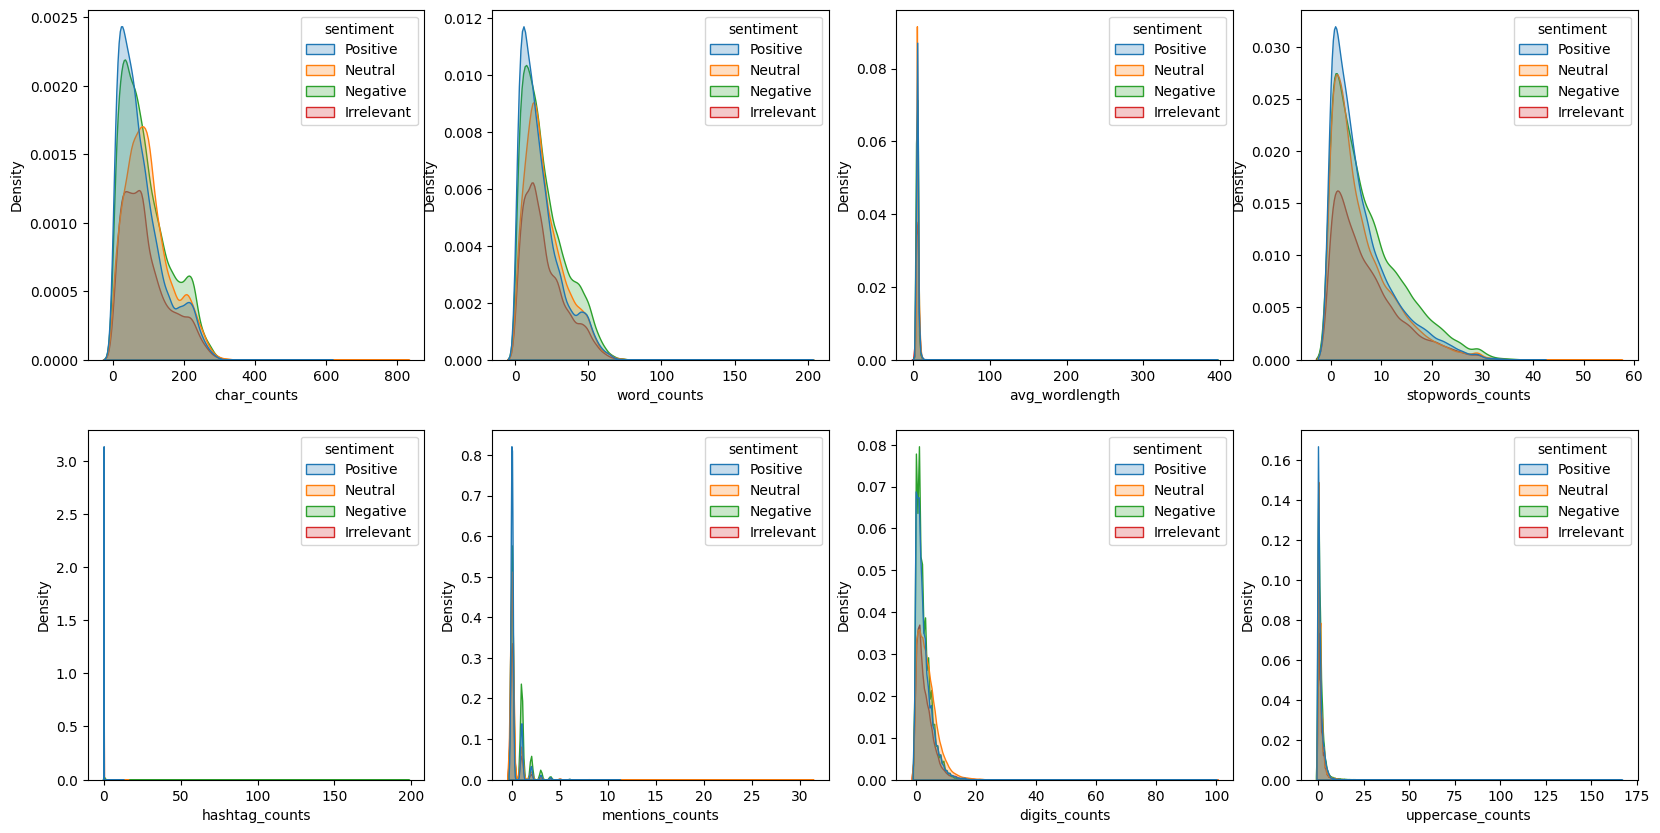

In [7]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# plot 2x4 grid histogram for each numerical feature
plt.figure(figsize=(20,10))

num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    plt.subplot(2,4, num_cols.get_loc(col)+1)

    # use sentiment as hue to see the distribution of each numerical feature
    # sns.distplot(df[col], label=col, color='red')
    # sns.histplot(x=col, hue='sentiment', data=df, color='green', bins=100, kde=True)
    sns.kdeplot(data=df, x=col, hue='sentiment', fill=True)

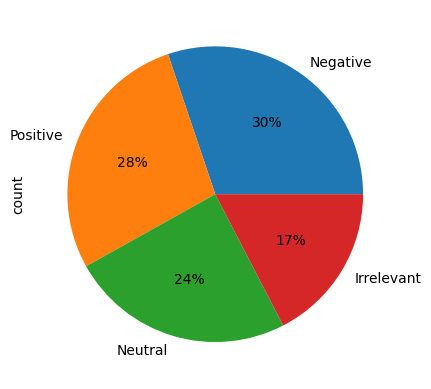

In [8]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

# word cloud
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

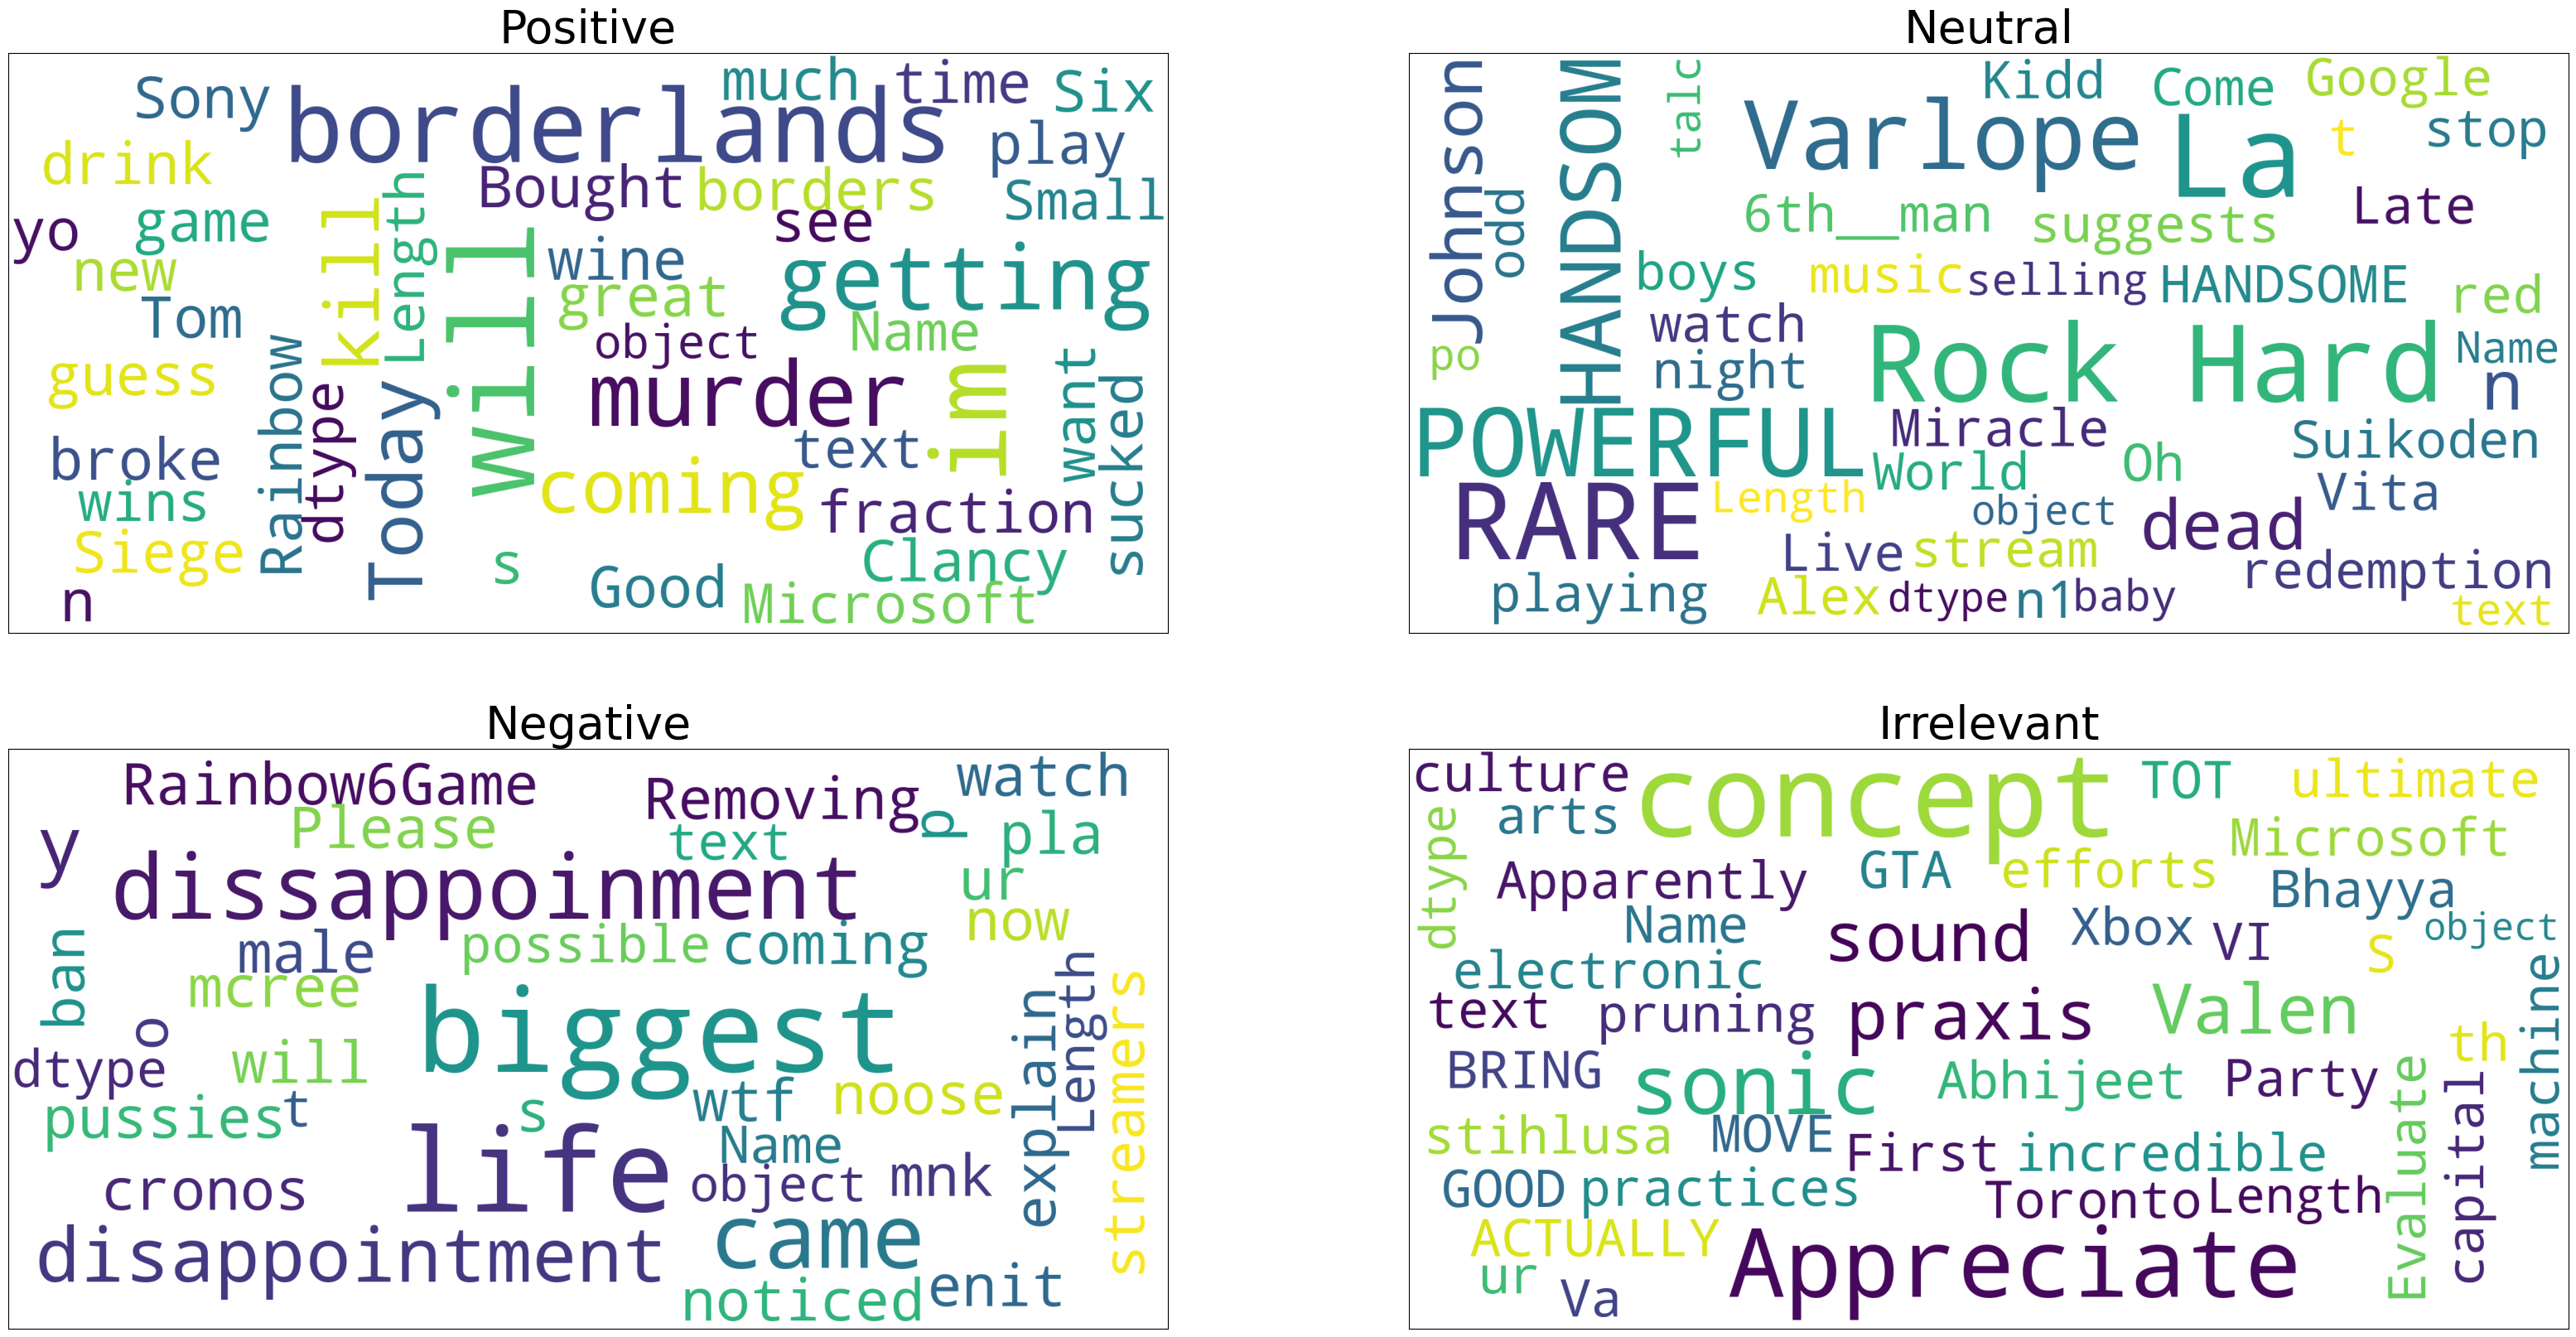

<Figure size 640x480 with 0 Axes>

In [9]:
# plot 2x2 grid word cloud for each sentiment
plt.figure(figsize=(40,20))

for index, col in enumerate(df['sentiment'].unique()):
    plt.subplot(2,2, index+1)
    # print(col)
    df1 = df[df['sentiment']==col]
    data = df1['text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)

plt.show()
plt.tight_layout()

In [10]:
# Data Cleaning
# lowercase, remove url, html, punctuations, retweet
import lxml
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: ps.remove_urls(x))
df['text'] = df['text'].apply(lambda x: ps.remove_html_tags(x))
df['text'] = df['text'].apply(lambda x: ps.remove_special_chars(x))
df['text'] = df['text'].apply(lambda x: ps.remove_rt(x))

In [11]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_test.shape


((59717,), (14930,))

In [13]:
import pickle
import gzip
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Model building
def train_model(X_train, y_train, stopwords):
    try:
        stopwords = list(stopwords)
        clf = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words=stopwords)),
            ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))
        ])
        clf.fit(X_train, y_train)
        return clf
    except Exception as e:
        print(f"Error training model: {e}")

# Evaluation
def evaluate_model(clf, X_test, y_test):
    try:
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        print(f"Model accuracy: {accuracy}")
        return accuracy
    except Exception as e:
        print(f"Error evaluating model: {e}")

# Save model with compression
def save_model(clf, filename):
    try:
        with gzip.open(filename, 'wb') as f:
            pickle.dump(clf, f)
        print(f"Model saved to {filename}")
    except Exception as e:
        print(f"Error saving model: {e}")

# Load model with compression
def load_model(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            clf = pickle.load(f)
        print(f"Model loaded from {filename}")
        return clf
    except Exception as e:
        print(f"Error loading model: {e}")

# Usage
stopwords = set(STOPWORDS)
clf = train_model(X_train, y_train, stopwords)
evaluate_model(clf, X_test, y_test)

#saveing model 

import pickle
pickle.dump(clf,open('twitter_sentiment.pkl','wb'))



Model accuracy: 0.9119223040857334


ValueError: Non valid compression method given: "wb". Possible values are {'zlib': <joblib.compressor.ZlibCompressorWrapper object at 0x000000000CAAA2D0>, 'gzip': <joblib.compressor.GzipCompressorWrapper object at 0x000000000CB0A7E0>, 'bz2': <joblib.compressor.BZ2CompressorWrapper object at 0x000000000CB0A810>, 'lzma': <joblib.compressor.LZMACompressorWrapper object at 0x000000000CB3C0E0>, 'xz': <joblib.compressor.XZCompressorWrapper object at 0x000000000CB3C4A0>, 'lz4': <joblib.compressor.LZ4CompressorWrapper object at 0x000000000CB3C4D0>}.

In [15]:
import joblib

# Dump with zlib compression
joblib.dump('twitter_sentiment.pkl', 'data.joblib', compress='zlib')

# Load with gzip compression
data = joblib.load('data.joblib')

In [1]:
import lzma

# Set the desired compressed file size in bytes (approximately 15 MB)
desired_size = 15 * 1024 * 1024

with open('twitter_sentiment.pkl', 'rb') as f_in, open('twitter_sentiment.xz', 'wb') as f_out:
    # Read the model data
    model_data = f_in.read()

    # Compress the model data with LZMA
    compressed_data = lzma.compress(model_data, preset=9, format=lzma.FORMAT_XZ)

    # Check the compressed size
    compressed_size = len(compressed_data)

    if compressed_size <= desired_size:
        # Write the compressed data to the output file
        f_out.write(compressed_data)
        print(f"Model compressed successfully. Compressed size: {compressed_size} bytes")
    else:
        print(f"Compressed size ({compressed_size} bytes) exceeds the desired size ({desired_size} bytes).")
        print("Adjusting compression level...")

        # Adjust the compression level until the desired size is reached
        for level in range(8, 0, -1):
            compressed_data = lzma.compress(model_data, preset=level, format=lzma.FORMAT_XZ)
            compressed_size = len(compressed_data)

            if compressed_size <= desired_size:
                # Write the compressed data to the output file
                f_out.write(compressed_data)
                print(f"Model compressed successfully at level {level}. Compressed size: {compressed_size} bytes")
                break
        else:
            print("Unable to compress the model to the desired size.")

Compressed size (46271100 bytes) exceeds the desired size (15728640 bytes).
Adjusting compression level...
Unable to compress the model to the desired size.


In [ ]:
X_test.tolist()[:20]


['add 4 callofduty and in roguecompany now teams o and everyone plays under play _ pso2 or ghostrecon i am also one of the best grovers in paladinsgame and best junkrat or mccree in overwatchleague dont forget best vulcan in smitegame i play destinythegame and fortnitegame',
 'tmobile you guys kids are really very slow in tuba star city az makes people go to google verizon',
 'i will make google top ranking high quality seo backlinks fiverrcom share nwewvp',
 'i know a guy whos tablet crashes today after 10 years he tried to fix it without google videos and plugging the tv into a different outlet no luck',
 'eamaddennfl movement is incredible',
 'internship manager',
 'bgs not in first by hearthstonebattlegrounds gameforcejphearthstonee3',
 'almost 2 years after launch and 3 cancelled season later bfv still now have game same in mp even though its fully functional in ghost campaign touche beyond every wire putting one nail in the coffin at a time',
 'so wait horses arthura poo hahaha s